In [1]:
from dotenv import load_dotenv
import os
import sys
from pathlib import Path

load_dotenv()

AVES_ROOT = Path("/home/sbetancu/aves/")
OSM_PATH = AVES_ROOT / "data" / "external" / "OSM"
COMUNAS_ROOT = Path(os.environ['COMUNAS_ROOT'])

In [2]:
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import pickle
from shapely.geometry import Polygon
from shapely.geometry import Point
import pyrosm
import os
import geopandas as gpd
from wordcloud import WordCloud
from collections import Counter


In [3]:
zones = gpd.read_file(AVES_ROOT / 'data' / 'processed' / 'scl_zonas_urbanas.json').set_index('ID')
zones.head()

,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry
ID,,,,,,,,,,,,,,,,,
103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,4.575649e+05,"POLYGON ((-70.65492 -33.55500, -70.65517 -33.5..."
104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.725462e+05,"POLYGON ((-70.67599 -33.55542, -70.67452 -33.5..."
106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,2.693838e+06,"POLYGON ((-70.67891 -33.55911, -70.68019 -33.5..."
115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.534193e+05,"POLYGON ((-70.67625 -33.55513, -70.67653 -33.5..."
116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.184305e+05,"POLYGON ((-70.66564 -33.55260, -70.66309 -33.5..."


In [4]:
comunas_gdf = gpd.read_file(COMUNAS_ROOT/'comunas.shp')
comunas_gdf = comunas_gdf.to_crs(epsg=3857)
comunas_gdf['NOM_COM'] = comunas_gdf['NOM_COM'].apply(lambda x: x.encode('latin1').decode('utf-8'))
print("CRS de gdf_comunas:", comunas_gdf.crs)

CRS de gdf_comunas: EPSG:3857


In [5]:
osm_clipped_file = OSM_PATH / 'clipped-scl-osm.pbf'

if not osm_clipped_file.exists():
    import os
    bounds = zones.total_bounds
    print(bounds)
    print(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
    os.system(f"osmconvert {OSM_PATH / 'chile-latest.osm.pbf'} -b={bounds[0]},{bounds[1]},{bounds[2]},{bounds[3]} -o={osm_clipped_file}")
else:
    print('data already available :D')


osm = pyrosm.OSM(str(osm_clipped_file))

data already available :D


In [6]:
# Definir el nombre del archivo para guardar los datos procesados
pkl_file = "footways.pkl"

# Verificar si el archivo ya existe
if os.path.exists(pkl_file):
    # Cargar el archivo .pkl utilizando pandas
    footways = pd.read_pickle(pkl_file)
    print("Datos cargados desde el archivo PKL.")
else:
    # Procesar los datos desde el principio
    # 1. Obtener la red de caminos para caminar
    network_edges = osm.get_network(network_type='walking')

    # 2. Filtrar los caminos peatonales (footways)
    footways = network_edges[network_edges['highway'] == 'footway']

    # 3. Convertir el sistema de coordenadas a EPSG:3857
    footways = footways.to_crs(epsg=3857)

    # 4. Guardar el resultado en un archivo .pkl utilizando el método to_pickle()
    footways.to_pickle(pkl_file)
    print("Datos procesados y guardados en un archivo PKL.")



Datos cargados desde el archivo PKL.


In [7]:
# Crear una lista para almacenar todas las entradas de datos
data_list = []
folder_path = '/home/sbetancu/aves/src/SOSAFE'
# Iterar sobre cada archivo en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        json_path = os.path.join(folder_path, file_name)
        
        with open(json_path, 'r', encoding='utf-8') as file:
            data = json.load(file)

        features = data['features']

        # Iterar a través de cada característica y extraer los datos necesarios
        for feature in features:
            properties = feature['properties']
            geometry = feature['geometry']

            # Crear un diccionario para cada entrada
            data_entry = {
                'uuid': properties.get('uuid'),
                'comments': properties.get('comments'),
                'created_at': properties.get('created_at'),
                'description': properties.get('description'),
                'likes': properties.get('likes'),
                'type': properties.get('type'),
                'longitude': geometry['coordinates'][0],
                'latitude': geometry['coordinates'][1]
            }

            # Añadir la entrada a la lista de datos
            data_list.append(data_entry)

In [8]:
df = pd.DataFrame(data_list)
df.head()

,uuid,comments,created_at,description,likes,type,longitude,latitude
0,a4520321-06e6-5f9f-ac95-1b6f0d5fd204,7,23/12/2023 00:28:12,Lira 1273 escándalos y música fuerte que no de...,2,13,-70.635766,-33.459534
1,e01d0e81-7c8f-57a1-aad3-314e4137680d,3,23/12/2023 00:29:12,Perrit@ perdid@ tiene collar pero no tiene placa,0,32,-70.694098,-33.522996
2,ca81ae41-ada5-5d81-8f0e-7f27bfe84a65,2,23/12/2023 00:29:12,"!!!! info , comparto , dato de incentivo , por...",0,33,-70.750095,-33.501617
3,3ee1671c-5b74-5465-9172-c36b78306e52,5,23/12/2023 00:33:12,Vi un fox terrier corriendo hacia el sur por S...,0,32,-70.500272,-33.390104
4,89813f06-5609-5ee6-9a8f-af7223e62aa5,12,23/12/2023 00:55:12,Plaza sttutgart y San Isidro con Sta Isabel co...,5,17,-70.642957,-33.449825


### LIMPIEZA: Limpiar, filtrar y preprocesar

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248216 entries, 0 to 248215
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uuid         248216 non-null  object 
 1   comments     248216 non-null  int64  
 2   created_at   248216 non-null  object 
 3   description  248216 non-null  object 
 4   likes        248216 non-null  int64  
 5   type         248216 non-null  int64  
 6   longitude    248216 non-null  float64
 7   latitude     248216 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 15.2+ MB


In [10]:
#Contar valores nulos en cada columna
valores_nulos = df.isnull().sum()

# Contar valores vacíos (donde las celdas tienen solo una cadena vacía '')
valores_vacios = (df == '').sum()

# Contar valores en blanco, asegurando que solo se aplique a columnas de tipo string
valores_en_blanco = df.select_dtypes(include=['object']).apply(lambda x: x.str.strip() == '').sum()

# Combinar todos los resultados en un DataFrame para visualizarlo fácilmente
resultados = pd.DataFrame({
    'Nulos': valores_nulos,
    'Vacíos': valores_vacios,
    'En Blanco': valores_en_blanco
}).fillna(0)  # Llenar valores NaN con 0 para columnas que no son de tipo string

# Mostrar el resultado
print(resultados)

             Nulos  Vacíos  En Blanco
comments         0       0        0.0
created_at       0       0        0.0
description      0    8982     8995.0
latitude         0       0        0.0
likes            0       0        0.0
longitude        0       0        0.0
type             0       0        0.0
uuid             0       0        0.0


In [11]:
# Eliminar filas con valores nulos
df = df.dropna()

# Eliminar filas con valores vacíos (donde las celdas tienen solo una cadena vacía '')
df = df.replace('', pd.NA).dropna()

# Eliminar filas con valores en blanco (que solo tienen espacios en blanco)
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x).replace('', pd.NA).dropna()

# Contar valores vacíos (donde las celdas tienen solo una cadena vacía '')
valores_vacios = (df == '').sum()

# Contar valores en blanco, asegurando que solo se aplique a columnas de tipo string
valores_en_blanco = df.select_dtypes(include=['object']).apply(lambda x: x.str.strip() == '').sum()

# Combinar todos los resultados en un DataFrame para visualizarlo fácilmente
resultados = pd.DataFrame({
    'Nulos': valores_nulos,
    'Vacíos': valores_vacios,
    'En Blanco': valores_en_blanco
}).fillna(0)  # Llenar valores NaN con 0 para columnas que no son de tipo string

# Mostrar el resultado
print(resultados)

             Nulos  Vacíos  En Blanco
comments         0       0        0.0
created_at       0       0        0.0
description      0       0        0.0
latitude         0       0        0.0
likes            0       0        0.0
longitude        0       0        0.0
type             0       0        0.0
uuid             0       0        0.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239221 entries, 0 to 248215
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   uuid         239221 non-null  object 
 1   comments     239221 non-null  int64  
 2   created_at   239221 non-null  object 
 3   description  239221 non-null  object 
 4   likes        239221 non-null  int64  
 5   type         239221 non-null  int64  
 6   longitude    239221 non-null  float64
 7   latitude     239221 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 16.4+ MB


Debido a que ninguna columna tiene valores nulos, quitaremos los datos irrelevantes. En este caso solo necesitamos los datos relacionados a cosas positivas. Primero veremos si la columna 'type' está relacionada a esto, viendo cuántos valores tiene

In [13]:
unique_types_sorted = sorted(df['type'].unique().tolist())
print(", ".join(map(str, unique_types_sorted)))

0, 1, 2, 6, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 31, 32, 33, 38, 39, 41, 42, 43, 46, 48, 49, 50, 52, 53, 56, 58, 67, 68, 70, 72, 73, 76, 89, 97, 101, 103, 108, 112, 116


Como no tenemos manera de saber a qué se refieren estos tipos, procederemos a filtrar la columna 'description' según palabras que podrían estar relacionadas a cosas negativas y positivas en el sector, esto se lleva a cabo en la seccion Separar Dataset

## GeoDataFrame 
añadimos columna de la respectiva comuna en la que se realiza el reporte

In [14]:
# Crear una GeoDataFrame a partir de los datos existentes
df['geometry'] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs(epsg=4326, inplace=True)

In [15]:
# Filtrar los puntos que están dentro del polígono de Santiago y crear una copia
gdf_rm = gdf.copy()

# Convertir la columna 'created_at' al tipo datetime
gdf_rm['created_at'] = pd.to_datetime(gdf_rm['created_at'], format='%d/%m/%Y %H:%M:%S')

# Crear la columna 'hora_exacta_del_dia' con la hora exacta
gdf_rm['hora_exacta_del_dia'] = gdf_rm['created_at'].dt.strftime('%H:%M')

# Crear una nueva columna 'hora' solo con la hora (sin minutos ni segundos)
gdf_rm['hora'] = gdf_rm['created_at'].dt.hour

# Crear una columna 'dia_semana' con los nombres de los días de la semana
gdf_rm['dia_semana'] = gdf_rm['created_at'].dt.day_name()

# Traducir los nombres de los días de la semana al español
dias_traduccion = {
    'Monday': 'lunes', 'Tuesday': 'martes', 'Wednesday': 'miércoles',
    'Thursday': 'jueves', 'Friday': 'viernes', 'Saturday': 'sábado', 'Sunday': 'domingo'
}
gdf_rm['dia_semana'] = gdf_rm['dia_semana'].map(dias_traduccion)

# Ordenar los datos por la columna 'likes' de forma descendente
gdf_rm = gdf_rm.sort_values(by='likes', ascending=False)

# Convertir el CRS a EPSG:3857
gdf_rm = gdf_rm.to_crs(epsg=3857)


In [16]:
# Archivo donde guardar el GeoDataFrame
output_file = 'gdf_with_comunas.pkl'

# Verificar si el archivo ya existe
if not os.path.exists(output_file):
    # Filtrar las comunas de la Región Metropolitana
    rm_comunas_gdf = comunas_gdf[comunas_gdf['REGION'].str.contains('Metropolitana', na=False)]
    # Asegurarse de que ambos GeoDataFrames tengan el mismo CRS
    gdf_rm = gdf_rm.to_crs(rm_comunas_gdf.crs)

    # Crear un índice espacial para optimizar las búsquedas
    rm_comunas_gdf = rm_comunas_gdf.set_index('NOM_COM')  # Indexar por nombre de la comuna
    spatial_index = rm_comunas_gdf.sindex

    # Asignar la comuna a cada punto usando solo las comunas de la Región Metropolitana
    gdf_rm['Comuna'] = gdf_rm.geometry.apply(
        lambda x: next(
            (comuna for comuna, geom in zip(rm_comunas_gdf.index, rm_comunas_gdf.geometry) if x.within(geom)),
            None  # Valor por defecto si no encuentra intersección
        )
    )
    # Eliminar puntos sin comuna asignada
    gdf_rm = gdf_rm[gdf_rm['Comuna'].notna()]
    # Guardar el GeoDataFrame en formato pickle
    gdf_rm.to_pickle(output_file)
    print(f"GeoDataFrame guardado en {output_file}")

    # Definir gdf_with_comunas para mantener la lógica consistente
    gdf_with_comunas = gdf_rm
else:
    # Cargar el GeoDataFrame desde el archivo existente usando pandas
    gdf_with_comunas = pd.read_pickle(output_file)

    # Asegurar que es un GeoDataFrame
    if not isinstance(gdf_with_comunas, gpd.GeoDataFrame):
        gdf_with_comunas = gpd.GeoDataFrame(gdf_with_comunas)
    
    print(f"GeoDataFrame cargado desde {output_file}")




GeoDataFrame cargado desde gdf_with_comunas.pkl


In [17]:
gdf_with_comunas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 222216 entries, 174083 to 62290
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   uuid                 222216 non-null  object        
 1   comments             222216 non-null  int64         
 2   created_at           222216 non-null  datetime64[ns]
 3   description          222216 non-null  object        
 4   likes                222216 non-null  int64         
 5   type                 222216 non-null  int64         
 6   longitude            222216 non-null  float64       
 7   latitude             222216 non-null  float64       
 8   geometry             222216 non-null  geometry      
 9   hora_exacta_del_dia  222216 non-null  object        
 10  hora                 222216 non-null  int32         
 11  dia_semana           222216 non-null  object        
 12  Comuna               222216 non-null  object        
dtypes: date

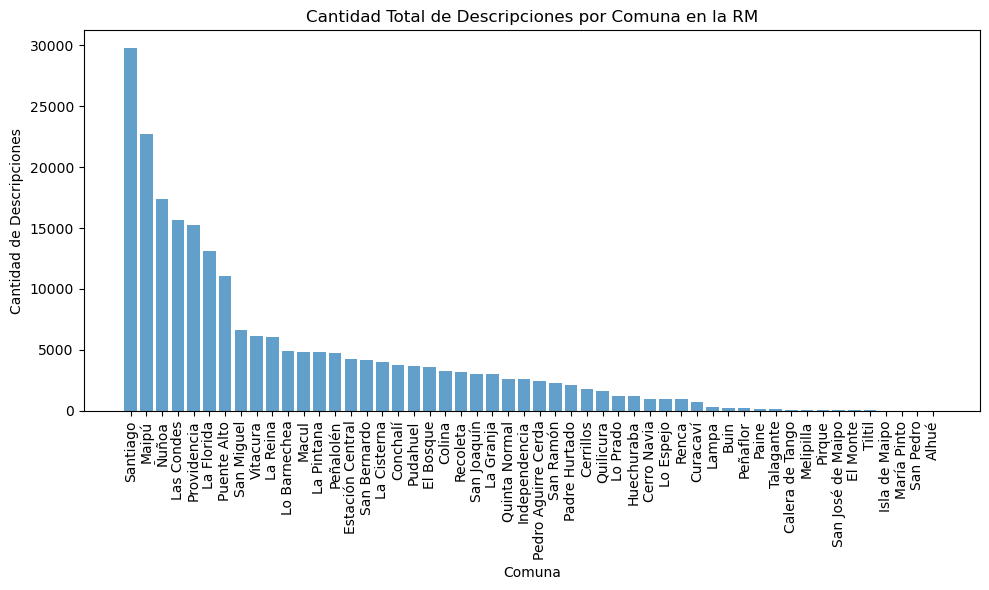

In [18]:
# Verificar si hay comunas asignadas
if gdf_with_comunas['Comuna'].notnull().any():
    # Contar el número de descripciones por comuna
    descriptions_by_comuna = gdf_with_comunas.groupby('Comuna').size().reset_index(name='total_descriptions')
    
    # Ordenar por la cantidad de descripciones
    descriptions_by_comuna = descriptions_by_comuna.sort_values(by='total_descriptions', ascending=False)
    
    # Crear el gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(descriptions_by_comuna['Comuna'], descriptions_by_comuna['total_descriptions'],alpha=0.7)
    plt.xlabel('Comuna')
    plt.ylabel('Cantidad de Descripciones')
    plt.title('Cantidad Total de Descripciones por Comuna en la RM')
    
    # Rotar las etiquetas del eje x a 90 grados
    plt.xticks(rotation=90)
    
    # Ajustar diseño
    plt.tight_layout()
    plt.show()
else:
    print("La columna 'Comuna' está vacía. Verifica la asignación de las comunas.")


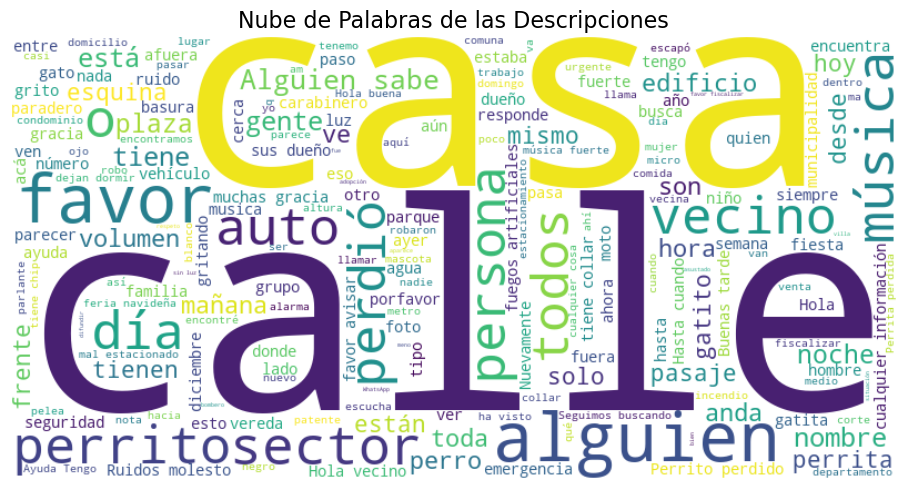

In [19]:
# Concatenar todas las descripciones en un solo texto
all_descriptions = " ".join(gdf_with_comunas['description'].dropna())

# Lista ampliada de stopwords en español
stopwords = set([
    'de', 'la', 'el', 'en', 'y', 'a', 'que', 'por', 'con', 'los', 'las', 'un', 'una', 
    'es', 'al', 'se', 'del', 'lo', 'como', 'para', 'su', 'más', 'este', 'esta', 'pero', 
    'ya', 'hay', 'si', 'no', 'ni', 'me', 'le', 'mi', 'tú', 'él', 'ella', 'nos', 'nosotros', 
    'ellos', 'ellas', 'usted', 'ustedes', 'también', 'porque', 'muy', 'uno', 'puede', 'sobre', 'todo'
])

# Crear la nube de palabras
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    stopwords=stopwords, 
    colormap='viridis'
).generate(all_descriptions)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Quitar los ejes
plt.title('Nube de Palabras de las Descripciones', fontsize=16)
plt.tight_layout()
plt.show()


## Separar DataSet : Negativo Y Positivo

In [20]:
negative_words = [
    "bache", "hueco", "asfalto roto", "pavimento en mal estado", "fisura", "grieta", "acera rota",
    "vereda en mal estado", "baldosas levantadas", "escombros en la acera", "falta de mantención",
    "desnivel", "escombros", "calle en mal estado", "falta de pavimento", "obstáculo", "construcción",
    "tuberías rotas", "materiales en la vía", "barrera en la calle", "falta de rampa", "escalón",
    "inaccesible", "no apto para sillas de ruedas", "dificultad para cruzar", "persona con movilidad reducida",
    "falta de iluminación", "luz rota", "faroles apagados", "calle oscura", "zona sin luz", "ruido",
    "contaminación sonora", "molestias por ruido", "zona ruidosa", "contaminación", "mal olor", "zona fea",
    "lugar sucio", "peligroso", "zona insegura", "asaltos", "robos", "vandalismo", "peligro", "resbaladizo",
    "inseguro", "zona en mal estado", "riesgo de accidente", "evitar esta ruta", "me siento incómodo",
    "no me gusta esta calle", "mucho tráfico", "congestión vehicular", "calle con autos", "ruido de autos"
]

In [21]:
# Nombre del archivo .pkl
output_file = "gdf_negative.pkl"

# Verificar si el archivo ya existe
if not os.path.exists(output_file):
    # Crear el GeoDataFrame filtrado
    gdf_negative = gdf_with_comunas[gdf_with_comunas['description'].str.contains('|'.join(negative_words), case=False, na=False)]
    
    # Guardar el GeoDataFrame en un archivo .pkl
    with open(output_file, "wb") as file:
        pickle.dump(gdf_negative, file)
    print(f"Archivo {output_file} creado y guardado.")
else:
    # Cargar el archivo existente
    with open(output_file, "rb") as file:
        gdf_negative = pickle.load(file)
    print(f"Archivo {output_file} cargado.")


Archivo gdf_negative.pkl cargado.


In [22]:
gdf_negative.head()

,uuid,comments,created_at,description,likes,type,longitude,latitude,geometry,hora_exacta_del_dia,hora,dia_semana,Comuna
177280,b355163d-83bd-5821-b664-f2e2d011eb05,101,2023-12-31 21:59:12,De venezolano a venezolano… se que la música e...,283,17,-70.644913,-33.448804,POINT (-7864155.795 -3955027.845),21:59,21,domingo,Santiago
11986,01e89779-60db-5a4a-a92a-8f53c80a14b4,21,2024-01-28 18:14:01,Muchas gracias a todos quienes me apoyaron a e...,157,33,-70.645579,-33.437978,POINT (-7864229.891 -3953583.622),18:14,18,domingo,Santiago
237420,25dba821-ac41-55d8-ab6d-a2a0ba67e88e,48,2024-01-08 01:12:01,Si su perro es bravo DEBE andar con correa o b...,141,32,-70.581829,-33.455087,POINT (-7857133.300 -3955866.052),01:12,1,lunes,Ñuñoa
38372,b40078e7-1c63-5c16-94bc-fabbb8b14c38,16,2023-12-25 04:40:12,Por qué no se dejan de tirar fuegos artificial...,136,14,-70.580267,-33.468018,POINT (-7856959.416 -3957591.519),04:40,4,lunes,Ñuñoa
144248,de952287-f44e-5a3c-89b4-6253350a3e2c,247,2024-01-29 01:10:01,Quiero denunciar un homicidio frustrado. Mi ve...,123,14,-70.588502,-33.528341,POINT (-7857876.097 -3965644.207),01:10,1,lunes,La Florida


In [23]:
positive_words = [
    "buen estado", "bien iluminado", "luz suficiente", "zona iluminada", "árbol", "jardín", "área verde",
    "paisaje", "sombras", "parque", "plaza", "banco", "agradable", "bonito", "hermoso", "pintoresco",
    "zona segura", "calle tranquila", "camino favorito", "paseo relajante", "camino que disfruto",
    "agradable para caminar", "cerca del metro", "acceso a buses", "estación de metro", "paradero",
    "soleado", "sombras", "calor", "viento", "lindo"
]

In [24]:
# Nombre del archivo .pkl
positive_output_file = "gdf_positive.pkl"

# Verificar si el archivo ya existe
if not os.path.exists(positive_output_file):
    # Filtrar el DataFrame usando las palabras positivas
    gdf_positive = gdf_with_comunas[gdf_with_comunas['description'].str.contains('|'.join(positive_words), case=False, na=False)]
    
    # Filtrar gdf_positive eliminando cualquier fila que tenga un uuid en gdf_negative
    gdf_positive = gdf_positive[~gdf_positive['uuid'].isin(gdf_negative['uuid'])]
    
    # Guardar el GeoDataFrame en un archivo .pkl
    with open(positive_output_file, "wb") as file:
        pickle.dump(gdf_positive, file)
    print(f"Archivo {positive_output_file} creado y guardado.")
else:
    # Cargar el archivo existente
    with open(positive_output_file, "rb") as file:
        gdf_positive = pickle.load(file)
    print(f"Archivo {positive_output_file} cargado.")

Archivo gdf_positive.pkl cargado.


In [25]:
gdf_positive.head()

,uuid,comments,created_at,description,likes,type,longitude,latitude,geometry,hora_exacta_del_dia,hora,dia_semana,Comuna
243063,2f529c26-2bbe-5dee-b2c7-fc6832832c06,79,2024-01-09 16:19:01,Hola\n\nHace cuatro años en esta plaza me enco...,415,32,-70.594597,-33.432211,POINT (-7858554.551 -3952814.244),16:19,16,martes,Providencia
204839,10130ccb-a6b4-5571-a2da-469ecbc96d2f,72,2024-01-27 20:15:01,Al wn que boto esta hermosura en una bolsa y l...,380,32,-70.670433,-33.372755,POINT (-7866996.662 -3944886.105),20:15,20,sábado,Conchalí
207850,0c37710b-f453-5310-b2e5-048a089bf77e,20,2023-11-29 19:44:11,Muchas gracias a todo el mundo que nos dio dat...,258,32,-70.668246,-33.512043,POINT (-7866753.131 -3963467.954),19:44,19,miércoles,La Cisterna
79261,362465f0-e951-5044-90d2-9306307e3d79,46,2024-01-12 00:48:01,Buenas noches a todossss!!!!\n\nse va el lunes...,200,32,-70.652047,-33.452039,POINT (-7864949.882 -3955459.458),00:48,0,viernes,Santiago
149203,a7381d7f-a0ef-53bf-9284-1f7625fda1be,26,2023-12-20 13:33:12,Aparecio LA BLANQUITA ESTABA EN EL PARQUE QUIN...,194,32,-70.671553,-33.440352,POINT (-7867121.320 -3953900.300),13:33,13,miércoles,Santiago
